## Librairies 

In [1]:
import numpy as np
import mpctools as mpc
import mpctools.plots as mpcplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import control as ctrl
import optuna
import time



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/ethanclement/Library/Python/3.12/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/ethanclement/Library/Python/3.12/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/ethanclement/Library/Python/3.12/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
    s

## State-space representation

In [2]:
# Longitudinal flight dynamics 
# Acont = [udot, wdot, qdot, thetadot, hdot]'
Acont = np.array([[-0.026, 0.074, -0.804, -9.809,0],
              [-0.242, -2.017, 73.297, -0.105, -0.001],
              [0.003, -0.135, -2.941, 0, 0],
              [0,       0,      1,    0,0],
              [-0.011, 1,        0 ,   -75, 0]])

# Bcont = [delta_th,delta_e]
Bcont = np.array([[4.594,0], [-0.0004, -13.735], [0.0002,-24.410], [0,0],[0,0]]) 

# Ccont = measured states theta and h
Ccont = np.array([[0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])

Dcont = np.array([[0], [0]])

## Controllability and observability

In [3]:
def pbh_controllability(A, B):
    n = A.shape[0]
    eigenvalues = np.linalg.eigvals(A)

    for i in eigenvalues:
        rank_test = np.linalg.matrix_rank(np.hstack([A - i * np.eye(n), B]))
        if rank_test < n:
            print(f"System is NOT controllable. Uncontrollable mode at lambda = {i:.4f}")
            return False

    print("System is controllable.")
    return True

def pbh_observability(A, C):
    n = A.shape[0]
    eigenvalues = np.linalg.eigvals(A)

    for j in eigenvalues:
        rank_test = np.linalg.matrix_rank(np.vstack([j * np.eye(n) - A, C]))
        if rank_test < n:
            print(f"System is NOT observable. Unobservable mode at lambda = {j:.4f}")
            return False

    print("System is observable.")
    return True

# Check controllability and observability
pbh_controllability(Acont, Bcont)
pbh_observability(Acont, Ccont)

System is controllable.
System is observable.


True

## MPC design

In [4]:
n = Acont.shape[0] # Number of states.
m = Bcont.shape[1] # Number of control elements

# Discretize.
dt = 0.25
Nt = 20 # Pas de temps
(A, B) = mpc.util.c2d(Acont,Bcont,dt)

def ffunc(x,u):
    """Linear discrete-time model."""
    return mpc.mtimes(A, x) + mpc.mtimes(B, u)
f = mpc.getCasadiFunc(ffunc, [n, m], ["x", "u"], "f")

umax = [1, 0.262]  # [Throttle, Elevator]
umin = [0, -0.262]
dumax = [0.1, 0.524]  # Rate constraints
dumin = [-0.1, -0.524]

# State constraints
theta_max = 0.349  
theta_min = -0.349

x_min = [-np.inf, -np.inf, -np.inf, theta_min, -np.inf]  
x_max = [np.inf, np.inf, np.inf, theta_max, np.inf]

# Set constraints in MPC
lb = dict(u=umin, du=dumin, x=x_min)
ub = dict(u=umax, du=dumax, x=x_max)

# Define Q and R matrices.
Q = np.diag([1, 1/0.12, 1/0.012, 1/0.12, 1/0.0172])
R = np.diag([1/0.52, 1/0.17452])

def lfunc(x,u):
    """Quadratic stage cost."""
    return mpc.mtimes(x.T, Q, x) + mpc.mtimes(u.T, R, u)

l = mpc.getCasadiFunc(lfunc, [n,m], ["x","u"], "l")

# Initial condition and sizes.
x0 = np.array([15, 0, 0, 0, 100])  # [u, w, q, θ, h]
N = {"x" : n, "u" : m, "t" : Nt}


## Solving MPC

In [5]:
# Solve MPC
solver = mpc.nmpc(f, l, N, x0, lb, ub,verbosity=0, isQP=True)
nsim = 40
t = np.arange(nsim + 1) * dt
xcl = np.zeros((n, nsim + 1))
xcl[:, 0] = x0
ucl = np.zeros((m, nsim))
ducl = np.zeros((m, nsim))
x4cl = np.zeros(nsim + 1)
for k in range(nsim):
    solver.fixvar("x", 0, x0)
    sol = mpc.callSolver(solver)
    print("Iteration %d Status: %s" % (k, sol["status"]))
    xcl[:, k] = x0
    x4cl[k] = x0[3]  
    ucl[:, k] = sol["u"][0, :]    
    if k > 0:
        ducl[:, k] = ucl[:, k] - ucl[:, k - 1]
    else:
        ducl[:, k] = ucl[:, k] - 0
    x0 = ffunc(x0, ucl[:, k])
xcl[:, nsim] = x0
x4cl[nsim] = x0[3]



qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.

Iteration 0 Status: Successful return.
I

## Closed-loop response

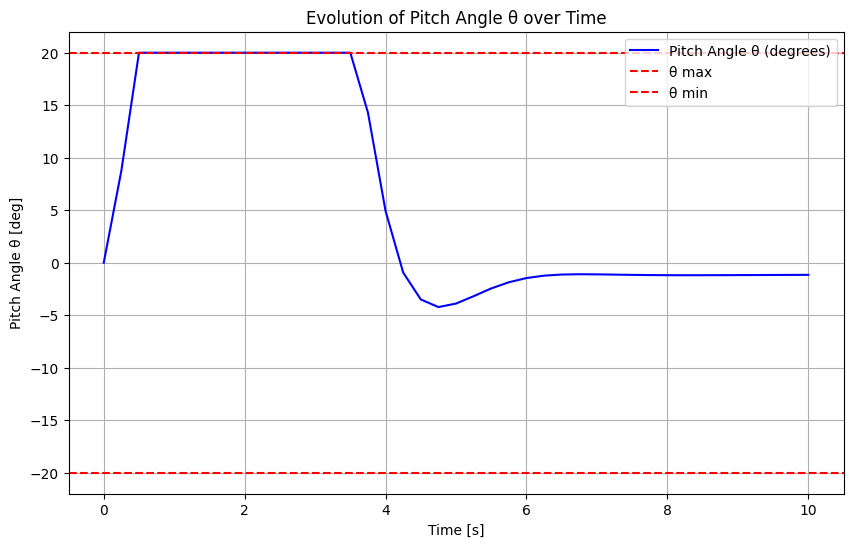

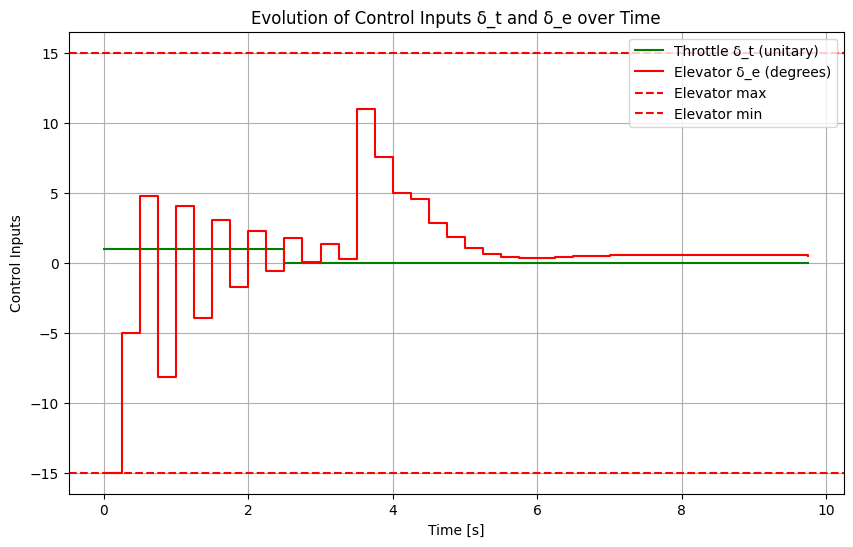

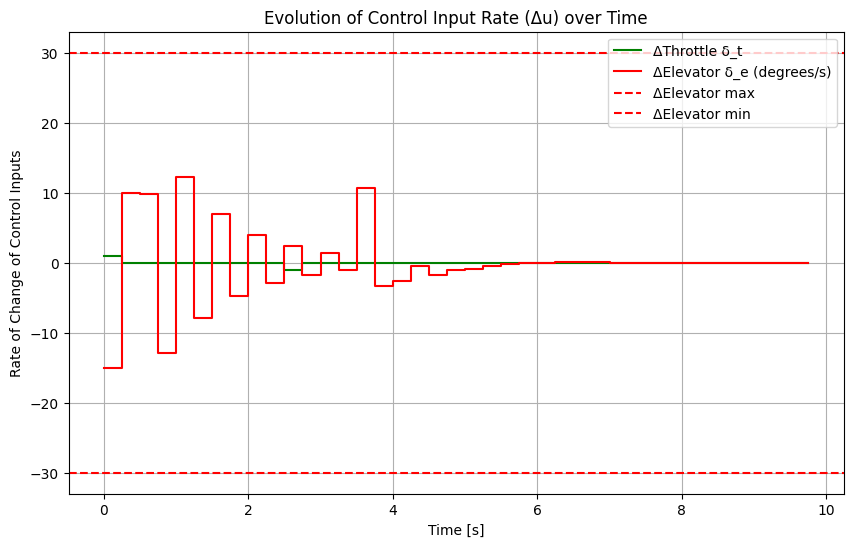

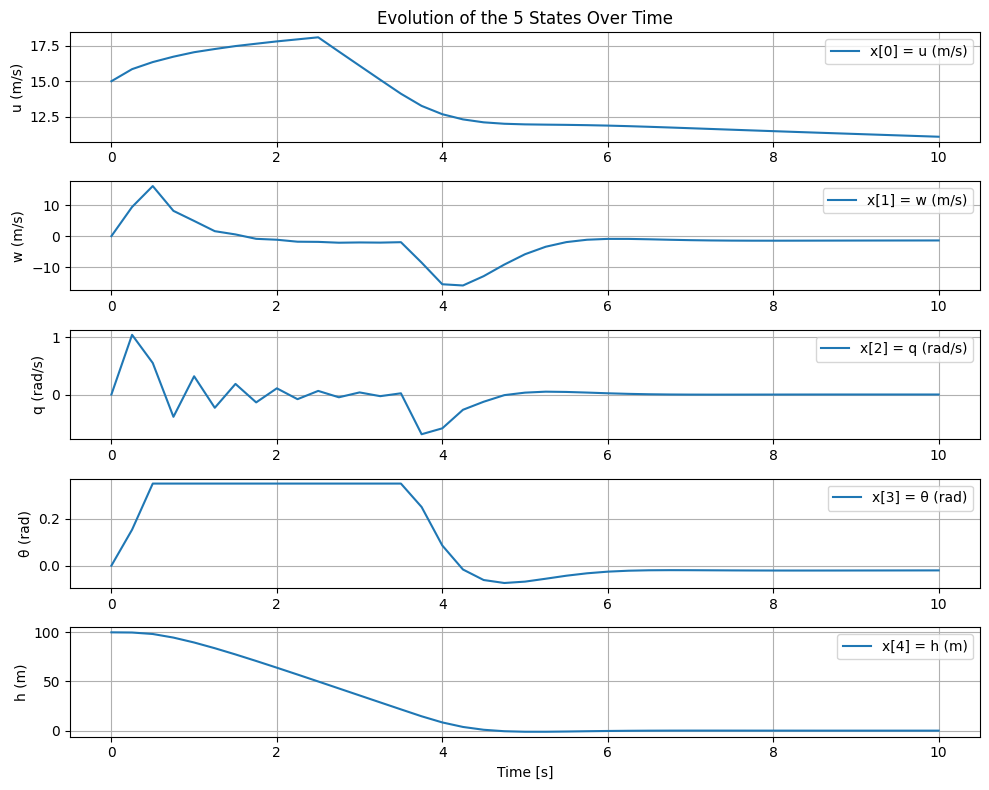

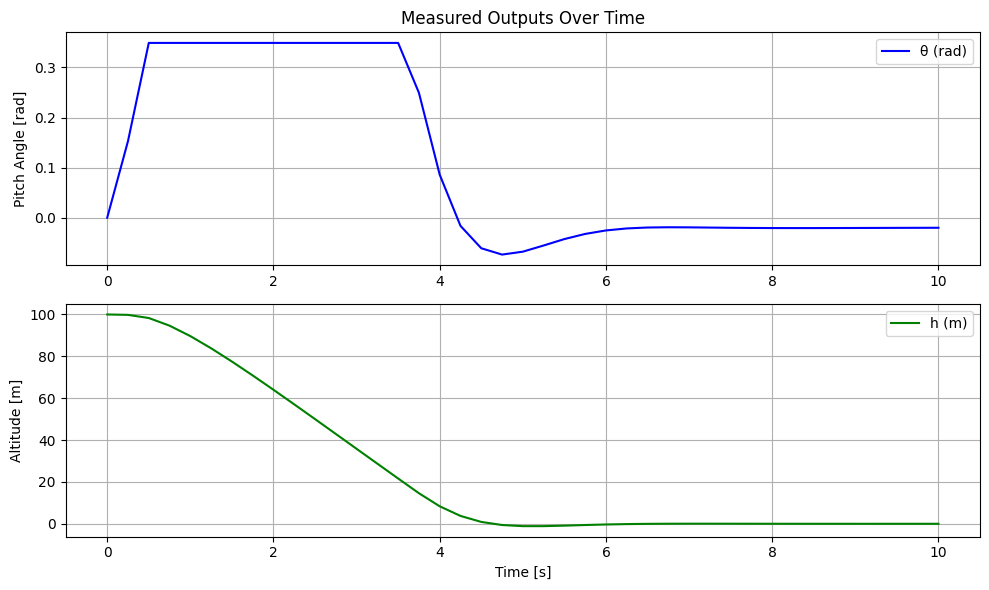

In [6]:
# Convert x4 from radians to degrees
x4_degrees = np.degrees(xcl[3, :])  
theta_max_degrees = np.degrees(theta_max)  
theta_min_degrees = np.degrees(theta_min)

# Plot x4 
plt.figure(figsize=(10, 6))
plt.plot(t, x4_degrees, label='Pitch Angle θ (degrees)', color='b')
plt.axhline(theta_max_degrees, color='r', linestyle='--', label='θ max')
plt.axhline(theta_min_degrees, color='r', linestyle='--', label='θ min')
plt.xlabel('Time [s]')
plt.ylabel('Pitch Angle θ [deg]')
plt.title('Evolution of Pitch Angle θ over Time')
plt.legend()
plt.grid()
plt.show()

# Convert control inputs
umax_degrees = [umax[0], np.degrees(umax[1])]  
umin_degrees = [umin[0], np.degrees(umin[1])]
ucl_degrees = np.copy(ucl)
ucl_degrees[1, :] = np.degrees(ucl[1, :])  

# Plot throttle and elevator 
plt.figure(figsize=(10, 6))
plt.step(t[:-1], ucl_degrees[0, :], where='post', label='Throttle δ_t (unitary)', color='g')
plt.step(t[:-1], ucl_degrees[1, :], where='post', label='Elevator δ_e (degrees)', color='r')
plt.axhline(umax_degrees[1], color='r', linestyle='--', label='Elevator max')
plt.axhline(umin_degrees[1], color='r', linestyle='--', label='Elevator min')
plt.xlabel('Time [s]')
plt.ylabel('Control Inputs')
plt.title('Evolution of Control Inputs δ_t and δ_e over Time')
plt.legend()
plt.grid()
plt.show()

# Convert rate of change of control inputs
ducl_degrees = np.copy(ducl)
ducl_degrees[1, :] = np.degrees(ducl[1, :])  

dumax_degrees = [dumax[0], np.degrees(dumax[1])]
dumin_degrees = [dumin[0], np.degrees(dumin[1])]

# Plot control rate
plt.figure(figsize=(10, 6))
plt.step(t[:-1], ducl_degrees[0, :], where='post', label='ΔThrottle δ_t', color='g')
plt.step(t[:-1], ducl_degrees[1, :], where='post', label='ΔElevator δ_e (degrees/s)', color='r')
plt.axhline(dumax_degrees[1], color='r', linestyle='--', label='ΔElevator max')
plt.axhline(dumin_degrees[1], color='r', linestyle='--', label='ΔElevator min')
plt.xlabel('Time [s]')
plt.ylabel('Rate of Change of Control Inputs')
plt.title('Evolution of Control Input Rate (Δu) over Time')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 8))

state_labels = ["u (m/s)", "w (m/s)", "q (rad/s)", "θ (rad)", "h (m)"]
for i in range(n):  # n=5
    plt.subplot(n, 1, i+1)
    plt.plot(t, xcl[i, :], label=f"x[{i}] = {state_labels[i]}")
    plt.ylabel(state_labels[i])
    plt.grid(True)
    if i == 0:
        plt.title("Evolution of the 5 States Over Time")
    if i == n-1:
        plt.xlabel("Time [s]")
    plt.legend(loc="best")

plt.tight_layout()
plt.show()

# Compute the measured outputs y for each time step
ycl = np.zeros((Ccont.shape[0], nsim+1))  # shape: (2, nsim+1)

for k in range(nsim+1):
    # y = C*x
    ycl[:, k] = Ccont @ xcl[:, k]  # (2,)

# Plot the measured outputs
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(t, ycl[0, :], label="θ (rad)", color="b")
plt.ylabel("Pitch Angle [rad]")
plt.title("Measured Outputs Over Time")
plt.grid(True)
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot(t, ycl[1, :], label="h (m)", color="g")
plt.xlabel("Time [s]")
plt.ylabel("Altitude [m]")
plt.grid(True)
plt.legend(loc="best")

plt.tight_layout()
plt.show()



## MHE 


In [7]:
# Import the libraries 
import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/Cellar/gcc/14.2.0_1/lib/gcc/current:' + os.environ.get('DYLD_LIBRARY_PATH', '')






import numpy as np
from numpy import random
from scipy import linalg
import mpctools as mpc
import matplotlib.pyplot as plt
from scipy.linalg import expm 

import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/Cellar/gcc/14.2.0_1/lib/gcc/current'


# Aircraft longitudinal state-space system 
# System dynamics
Acont = np.array([
    [-0.026, 0.074, -0.804, -9.809, 0], # udot forward velocity
    [-0.242, -2.017, 73.297, -0.105, -0.001], # wdot vertical velocity
    [0.003, -0.135, -2.941, 0, 0], # qdot pitch rate
    [0, 0, 1, 0, 0], # thetadot pitch angle
    [-0.011, 1, 0, -75, 0]# hdot altitude
])

# Control input matrix :  throttle and elevator
Bcont = np.array([
    [4.594, 0],
    [-0.0004, -13.735],
    [0.0002, -24.410],
    [0, 0],
    [0, 0]
])
# Output matrix
Ccont = np.array([
    [1, 0, 0, 0, 0],    # xdot
    [0, 0, 0, 1, 0],    # theta
    [0, 0, 0, 0, 1]     # h
])


# MHE parameters
Delta = 0.1          # Sampling time
Nt = 50              # Horizon length
Nsim = 50            # Simulation length

Nx, Nu, Ny = 5, 2, 3 # System dimensions 
Nw, Nv, Nc = Nx, Ny, 4 # Nc -> # constraints Nv and Nv -> noise sizes

t = np.arange(Nsim + 1) * Delta # Time vector

# Gcont: Noise influence matrix (used for process noise in continuous-time)
Gcont = Acont @ np.linalg.inv(expm(Acont * Delta) - np.eye(Nx))

# Discretize continuous system for simulation
(A, B) = mpc.util.c2d(Acont, Bcont, Delta)

# Continuous-time dynamics function
def fcontinuous_func(x, u, w):
    return mpc.mtimes(Acont, x) + mpc.mtimes(Bcont, u) + mpc.mtimes(Gcont, w)
fcontinuous = mpc.getCasadiFunc(fcontinuous_func, [Nx, Nu, Nw], ["x", "u", "w"], "f")

# Discrete-time dynamics function
def Fdiscrete_func(x, u, w):
    return mpc.mtimes(A, x) + mpc.mtimes(B, u) + w
Fdiscrete = mpc.getCasadiFunc(Fdiscrete_func, [Nx, Nu, Nw], ["x", "u", "w"], "F")

# Measurement function
def H_func(x):
    return mpc.mtimes(Ccont, x)
H = mpc.getCasadiFunc(H_func, [Nx], ["x"], "H")

# Process noise covariance for model uncertainty
Q = 0.01 * np.eye(Nx)
Qhalf = linalg.cholesky(Q, lower=True)
Qinv = np.linalg.inv(Q)

# Measurement noise covariance for sensor uncertainty
R = 0.1 * np.eye(Ny)
Rhalf = linalg.cholesky(R, lower=True)
Rinv = np.linalg.inv(R)

# Simulate system with noise
random.seed(927)

x0 = np.array([0, 0, 0, 0.0, 0])   # initial true state
x0hat = np.zeros(Nx) # initial state estimate

# Generate control inputs
omega = 2 * np.pi / (Nsim * Delta)
u = np.vstack((np.sin(omega * t), np.cos(omega * t))).T[:-1]

# Generate process and measurement noise
w = Qhalf @ random.randn(Nw, Nsim) # process noise
w = w.T
v = Rhalf @ random.randn(Nv, Nsim + 1)  # measurement noise
v = v.T

# Allocate arrays for true states and measurements
x = np.zeros((Nsim + 1, Nx))
y = np.zeros((Nsim + 1, Ny))
x[0, :] = x0

# Simulate the true system -> discrete-time model + noise
for k in range(Nsim + 1):
    y[k] = np.squeeze(H(x[k])) + v[k] # measured output with noise
    if k < Nsim:
        x[k + 1] = np.squeeze(Fdiscrete(x[k], u[k], w[k])) # next state

# MHE 
# Cost function for noise residuals
def l_func(w, v):
    return mpc.mtimes(w.T, Qinv, w) + mpc.mtimes(v.T, Rinv, v)
l = mpc.getCasadiFunc(l_func, [Nw, Nv], ["w", "v"], "l")

# Cost function for initial state deviation
def lx_func(x):
    return 10 * mpc.mtimes(x.T, x)
lx = mpc.getCasadiFunc(lx_func, [Nx], ["x"], "lx")

xhat = np.zeros((Nsim + 1, Nx)) # estimated states
xhat[0] = x0hat
solver = None

"""
At each step we:

Gather data from the sliding window (past + present data).

Solve an optimization problem to estimate the states.

Store the most recent estimate for the next step.


"""

for t_step in range(Nsim): 
    # Determine the length of the current estimation window
    M = min(max(t_step,1), Nt) # number of steps inside the estimation window. Not a full window -> use all data available else fixed-length window over Nt. Prevent window 0 at start.
    N_window = {"t": M, "x": Nx, "y": Ny, "u": Nu, "c": Nc} # Define problem dimensions 
    tmin = max(0, t_step - Nt) # Window start time
    tmax = t_step + 1 # Window end time

    # Extract current window of inputs and outputs
    u_window = u[tmin:tmax-1] if t_step >= 1 else np.zeros((0, Nu)) # input history over window
    y_window = y[tmin:tmax] # output history over window

    # Initialize or update solver
    if solver is None or t_step < Nt: # Startup case or when window is still filling

        y_window = y[tmin:tmax]
        u_window = u[tmin:tmax-1] if t_step>=1 else np.zeros((0, Nu))

        M = y_window.shape[0] - 1   
        N_window = {"t": M, "x": Nx, "y": Ny, "u": Nu, "c": Nc}
        solver = mpc.nmhe(fcontinuous, H, u_window, y_window, l, N_window,
                          lx, xhat[t_step], verbosity=0,
                          Delta=Delta)
    else: # Reuse solver to avoid re-creating it and update u,y and x0bar   
        solver.par["u"] = list(u_window) 
        solver.par["y"] = list(y_window)
        solver.par["x0bar"] = xhat[t_step]

    sol = mpc.callSolver(solver)
    if sol["status"] != "Solve_Succeeded":
        print(f"MHE failed at step {t_step}")
        break

    # Save the last state estimate of the window as current estimate
    xhat[t_step + 1] = sol["x"][-1]

# Plots
fig, axs = plt.subplots(Nx, 1, figsize=(8, Nx * 2))
for i in range(Nx):
    axs[i].plot(t, x[:, i], label=f"True $x_{i}$")
    axs[i].plot(t, xhat[:, i], '--', label=f"Estimated $x_{i}$")
    axs[i].set_ylabel(f"$x_{i}$")
    axs[i].legend()
axs[-1].set_xlabel("Time [s]")
plt.tight_layout()
plt.show()




CasADi - 2025-05-16 00:22:34 WARNING(".../casadi/core/casadi_os.cpp:166: Assertion "handle!=nullptr" failed:
PluginInterface::load_plugin: Cannot load shared library 'libcasadi_nlpsol_ipopt.dylib': 
   (
    Searched directories: 1. casadipath from GlobalOptions
                          2. CASADIPATH env var
                          3. PATH env var (Windows)
                          4. LD_LIBRARY_PATH env var (Linux)
                          5. DYLD_LIBRARY_PATH env var (osx)
    A library may be 'not found' even if the file exists:
          * library is not compatible (different compiler/bitness)
          * the dependencies are not found
   )
  Tried '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/casadi' :
    Error code: dlopen(/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/casadi/libcasadi_nlpsol_ipopt.dylib, 0x0005): Library not loaded: @rpath/libgfortran.5.dylib
  Referenced from: <C2C42527-794E-31BB-937E-883

RuntimeError: .../casadi/core/plugin_interface.hpp:292: Plugin 'ipopt' is not found.